### Produce output

In [39]:
from transformers import BertTokenizer, TFBertModel, pipeline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

import pandas as pd
import tensorflow as tf


In [4]:
ru = pd.read_csv('./Slavic-BERT-NER/russian_nouns_cased.csv', index_col = 0)
ru

,uncased,genitive,dative,accusative,instrumental,prepositional
0,человек,человека,человеку,человека,человеком,человеке
1,время,времени,времени,время,временем,времени
2,рука,руки,руке,руку,рукой,руке
3,дело,дела,делу,дело,делом,деле
4,день,дня,дню,день,днём,дне
...,...,...,...,...,...,...
1794,Рим,Рима,Риму,Рим,Римом,Риме
1795,жилец,жильца,жильцу,жильца,жильцом,жильце
1796,обсуждение,обсуждения,обсуждению,обсуждение,обсуждением,обсуждении
1797,заря,зари,заре,зарю,зарёй,заре


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = TFBertModel.from_pretrained("bert-base-multilingual-cased")

# мая девушка говорила мне по-русски
text = "человек!"
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [69]:
type(model)

transformers.models.bert.modeling_tf_bert.TFBertModel

In [6]:
tokenizer.tokenize(text) 

['человек', '!']

In [7]:
output[0].shape

TensorShape([1, 4, 768])

In [63]:
text_ru = "der Apfel"
encoded_input_ru = tokenizer(text_ru, return_tensors='tf')
output_ru = model(encoded_input_ru)

Explained variances: [0.46114576 0.21911258 0.17932235 0.09868569]


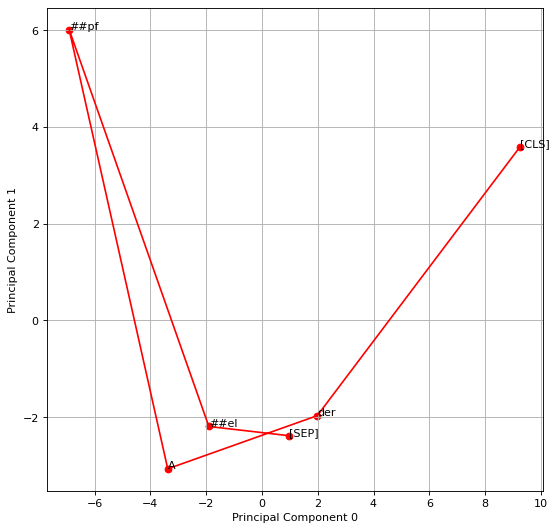

In [64]:
make_pca(output_ru[0].numpy().squeeze(), 4, 0, 1, text_ru)

Explained variances: [0.42338642 0.22663875 0.19278878 0.1062923 ]


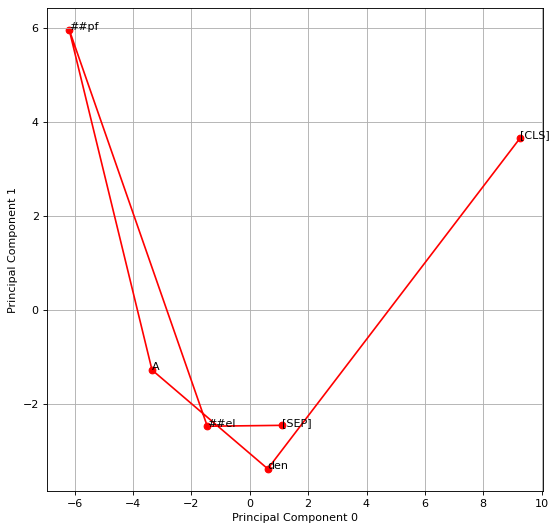

In [65]:
text_ru = "den Apfel"
encoded_input_ru = tokenizer(text_ru, return_tensors='tf')
output_ru = model(encoded_input_ru)

make_pca(output_ru[0].numpy().squeeze(), 4, 0, 1, text_ru)

## analyzing outputs

In [60]:
avg_vecs = []

for x in ru['uncased']:
    
    encoded_input_ru = tokenizer(x, return_tensors = 'tf')
    output_ru = model(encoded_input_ru)
    
    avg_vecs.append(tf.reduce_mean(output_ru.last_hidden_state, axis = 1))
    
    if len(avg_vecs) % 100 == 0:
        print(len(avg_vecs))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [46]:
avg_vecs_genitive = []

for x in ru['genitive']:
    
    encoded_input_ru = tokenizer(x, return_tensors = 'tf')
    output_ru = model(encoded_input_ru)
    
    avg_vecs_genitive.append(tf.reduce_mean(output_ru.last_hidden_state, axis = 1))
    
    if len(avg_vecs_genitive) % 100 == 0:
        print(len(avg_vecs_genitive))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [48]:
avg_vecs_np = np.array([x.numpy() for x in avg_vecs])
avg_vecs_np = avg_vecs_np.squeeze()
avg_vecs_np.shape

(1799, 768)

In [49]:
avg_vecs_gen_np = np.array([x.numpy() for x in avg_vecs_genitive])
avg_vecs_gen_np = avg_vecs_gen_np.squeeze()
avg_vecs_gen_np.shape

(1799, 768)

In [51]:
diff = avg_vecs_np - avg_vecs_gen_np
diff.shape

(1799, 768)

In [53]:
pca = PCA(n_components = 10)

pca_ru_diff = pca.fit_transform(diff)
print("Explained variances:", pca.explained_variance_ratio_)

Explained variances: [0.05507899 0.04257601 0.03345853 0.03152234 0.02779334 0.02100995
 0.01895695 0.01766862 0.01593635 0.01489293]


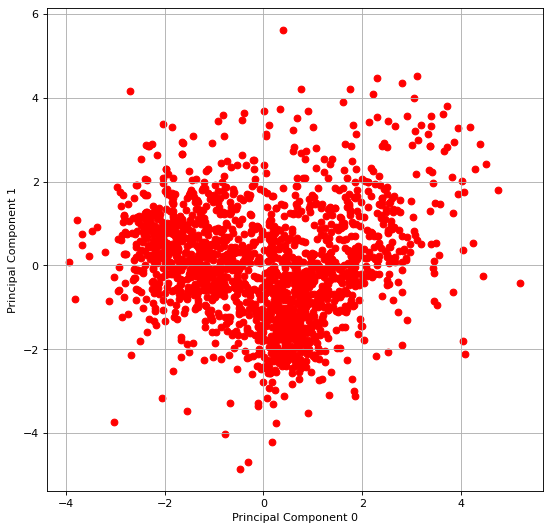

In [54]:
plt.figure(figsize=(8, 8), dpi=80)
plt.grid()
plt.xlabel("Principal Component " + str(0))
plt.ylabel("Principal Component " + str(1))
    
plt.scatter(pca_ru_diff[:,0], pca_ru_diff[:,1], color = "r")

Explained variances: [0.00342822 0.00340887 0.00336881 0.00334611 0.00325989 0.00322637
 0.00320804 0.00317717 0.00316285 0.0031453 ]


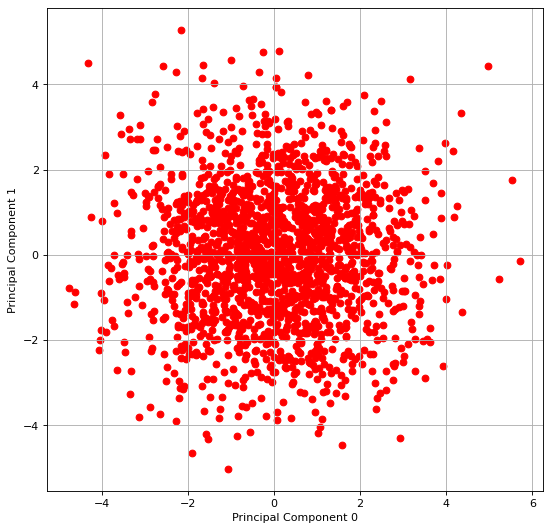

In [59]:
pca = PCA(n_components = 10)

pca_ru_diff = pca.fit_transform(np.random.randn(*diff.shape))
print("Explained variances:", pca.explained_variance_ratio_)

plt.figure(figsize=(8, 8), dpi=80)
plt.grid()
plt.xlabel("Principal Component " + str(0))
plt.ylabel("Principal Component " + str(1))
    
plt.scatter(pca_ru_diff[:,0], pca_ru_diff[:,1], color = "r")

## pca of individual hidden outputs

In [ ]:
mat = np.random.rand(9, 768)

mat.shape

def make_pca(M, n_pcs, pc1, pc2, text):
    
    pca = PCA(n_components = n_pcs)
    M_pca = pca.fit_transform(M)
    
    print("Explained variances:", pca.explained_variance_ratio_)
    
    #print(M_pca[:,[pc1, pc2]].shape)
    
    plt.figure(figsize=(8, 8), dpi=80)
    plt.grid()
    plt.xlabel("Principal Component " + str(pc1))
    plt.ylabel("Principal Component " + str(pc2))
    
    plt.scatter(M_pca[:,pc1], M_pca[:,pc2], color = "r")
    plt.plot(M_pca[:,pc1], M_pca[:,pc2], color = "r")
    
    
    if text:
        labels = tokenizer.tokenize(text)
        labels = ['[CLS]'] + labels + ['[SEP]']
        
        for i, txt in enumerate(labels):
            plt.annotate(txt, (M_pca[:,pc1][i], M_pca[:,pc2][i]))


In [12]:
text_ru = "человека!"
encoded_input_ru = tokenizer(text_ru, return_tensors='tf')
output_ru = model(encoded_input_ru)

In [36]:
print(output_ru.last_hidden_state) # better to take the average of this to assess output

tf.Tensor(
[[[-0.7817353  -0.45648402  0.60389733 ...  0.65457624  0.2821358
    0.09449863]
  [-0.9629171  -0.3744311   0.9046609  ...  0.873118    0.07696266
    0.31212607]
  [-0.8426639  -0.4254579   0.49334598 ...  0.6093422   0.23184083
    0.04706534]
  [-0.9087195  -0.33146617  0.8714543  ...  0.35896084  0.12936535
    0.17726916]]], shape=(1, 4, 768), dtype=float32)


In [42]:
tf.reduce_mean(output_ru.last_hidden_state, axis = 1)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-8.74008954e-01, -3.96959782e-01,  7.18339622e-01,
         5.31682491e-01, -2.24517673e-01,  9.26148295e-02,
        -1.44187495e-01, -3.41329008e-01,  2.54653782e-01,
         9.09515440e-01,  1.13877797e+00, -4.24306363e-01,
         6.74433708e-01,  3.61233532e-01,  9.22052562e-02,
        -6.36861801e-01, -1.35932043e-01,  2.28970990e-01,
         3.92082244e-01,  1.85974807e-01,  8.20600152e-01,
         3.48286033e-02,  1.50307208e-01, -1.65040977e-02,
        -3.81280124e-01,  3.24466169e-01, -6.50015295e-01,
        -6.18233204e-01, -3.77904952e-01,  5.61570883e-01,
         4.32411134e-01,  5.34651518e-01,  1.14194043e-02,
        -7.98394382e-02, -4.77401260e-03,  2.69400567e-01,
        -4.57161725e-01,  2.79449522e-01,  2.17415258e-01,
         2.52590120e-01, -8.36147189e-01,  2.05096483e-01,
        -4.41975236e-01, -2.47583315e-01, -5.67961335e-01,
         1.14629954e-01,  7.89294094e-02,  1.88871622e-01,
      

Explained variances: [6.1679322e-01 2.3365620e-01 1.4955053e-01 2.9757419e-14]


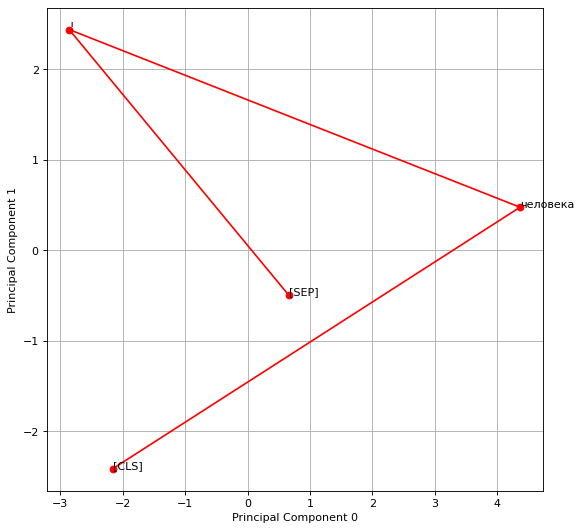

In [13]:
make_pca(output_ru[0].numpy().squeeze(), 4, 0, 1, text_ru)

Explained variances: [0.71671516 0.18778722]


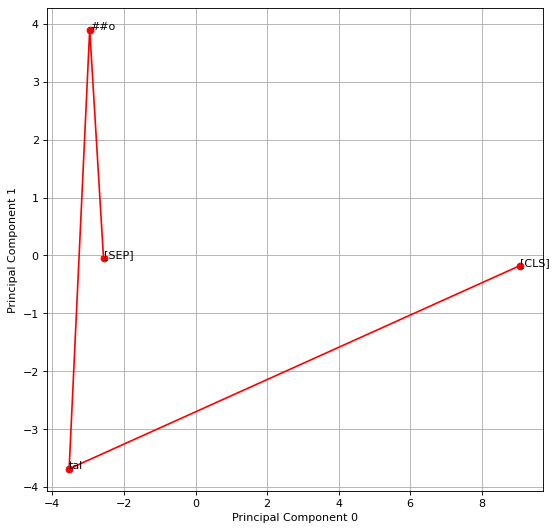

In [14]:
text_fi = "talo" #"我爱我的女朋有"
encoded_input_fi = tokenizer(text_fi, return_tensors='tf')
output_fi = model(encoded_input_fi)

make_pca(output_fi[0].numpy().squeeze(), 2, 0, 1, text_fi)

Explained variances: [0.6369168  0.23624834]


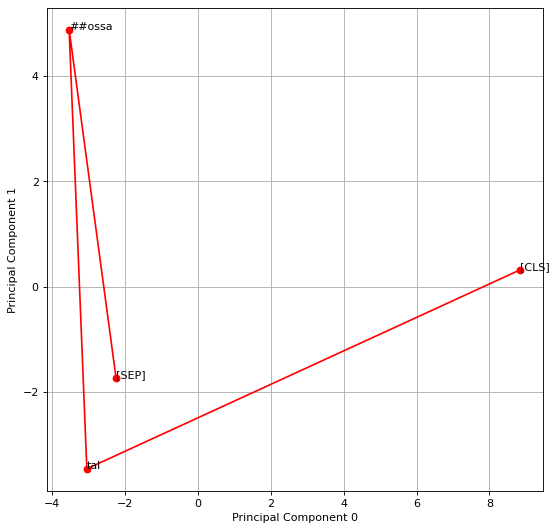

In [15]:
text_fi = "talossa" #"我爱我的女朋有"
encoded_input_fi = tokenizer(text_fi, return_tensors='tf')
output_fi = model(encoded_input_fi)

make_pca(output_fi[0].numpy().squeeze(), 2, 0, 1, text_fi)

Explained variances: [4.5844895e-01 2.6692030e-01 1.8645886e-01 8.8171981e-02 1.4391325e-14]


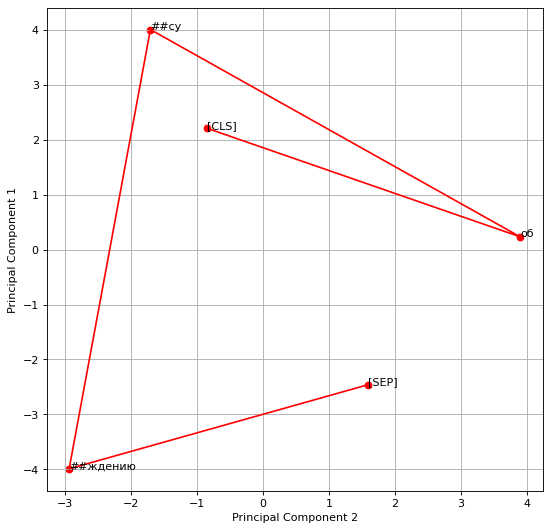

In [16]:
text_tr = "обсуждению" #"я кохаю свою дівчину"
encoded_input_tr = tokenizer(text_tr, return_tensors='tf')
output_tr = model(encoded_input_tr)

make_pca(output_tr[0].numpy().squeeze(), 5, 2, 1, text_tr)

In [194]:
len({x:len(x) for x in {'xyz'*i for i in range(5)}})

5

### Masking fun

In [37]:
unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')
unmasker("Моя [MASK] красивая")#("我的女[MASK]友很漂亮")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'sequence': 'Моя любовь красивая',
  'score': 0.19478608667850494,
  'token': 76976,
  'token_str': 'любовь'},
 {'sequence': 'Моя - красивая',
  'score': 0.10647248476743698,
  'token': 118,
  'token_str': '-'},
 {'sequence': 'Моя, красивая',
  'score': 0.05247558653354645,
  'token': 117,
  'token_str': ','},
 {'sequence': 'Моя жизнь красивая',
  'score': 0.04173823073506355,
  'token': 27264,
  'token_str': 'жизнь'},
 {'sequence': 'Моя страна красивая',
  'score': 0.02735201083123684,
  'token': 18512,
  'token_str': 'страна'}]